In [17]:
"""
Credits for this implementation go to @Suji04, from which I took most of the code for this notebook,
which saved me lots of time writing the pure functionality of the nodes and recursion.
"""
import numpy as np
import pandas as pd

df = pd.read_csv('../Datasets/Iris.csv')

In [18]:
df.drop('Id', axis=1, inplace=True)

In [19]:
df.loc[df['Species']=='Iris-setosa', 'Species'] = 0
df.loc[df['Species']=='Iris-versicolor', 'Species'] = 1
df.loc[df['Species']=='Iris-virginica', 'Species'] = 2

In [20]:
df_vals = df.values

In [ ]:
# Find a way to build a computational network able to run like a tree, suitable for recursive binary splitting
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor '''

        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        # for leaf node
        self.value = value


In [15]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''

        # initialize the root of the tree
        self.root = None

        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''

        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        """ find the best split """

        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")

        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        # return best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''

        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):
        ''' function to compute entropy '''

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        ''' function to compute gini index '''

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def gini_impurity(self, y):
        """
        :param y: Numpy array containing the classes
        :return: Gini impurity for the provided set of y
        """
        res = 1
        for ul in np.unique(y):
            res -= np.power(len(y[y==ul]) / len(y), 2)
        return res

    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        ''' function to train the tree '''

        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        ''' function to predict new dataset '''

        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''

        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [37]:
X = df_vals[:,:-1]
y = df_vals[:,-1]

In [42]:
print(X.shape)
print(y.reshape(-1,1).shape)

(150, 4)
(150, 1)


In [43]:
d = DecisionTreeClassifier()
d.fit(df_vals[:,:-1], df_vals[:,-1].reshape(-1,1))

In [46]:
d.print_tree()

X_2 <= 1.9 ? 0.3333333333333334
 left:0
 right:X_3 <= 1.7 ? 0.38969404186795487
  left:X_2 <= 4.9 ? 0.08239026063100136
    left:1
    right:2
  right:X_2 <= 4.8 ? 0.013547574039067499
    left:2
    right:2


In [49]:
d.predict(X[2,:].reshape(1, -1))

[0]

In [57]:
cov = np.array([
    [1,0],
    [0,1]
])

# Gaussian distribution n1
sample_1 = np.random.multivariate_normal(mean=np.array([1,2]), cov=cov, size=300)
y_1 = np.zeros(shape=len(sample_1[:, 0]))

In [58]:
sample_2 = np.random.multivariate_normal(mean=np.array([4,3]), cov=cov, size=300)
y_2 = np.ones(shape=len(sample_2[:,0]))


In [59]:
X = np.vstack((sample_1, sample_2))
y = np.hstack((y_1, y_2)).reshape(-1, 1)

In [60]:
X_y=np.concatenate((X,y), axis=1)

In [61]:
np.random.shuffle(X_y)

In [86]:
d = DecisionTreeClassifier(min_samples_split=2, max_depth=2)
d.fit(X_y[:, :-1], X_y[:, -1].reshape(-1,1))

In [87]:
d.print_tree()

X_0 <= 2.320060139711222 ? 0.3994660734149056
 left:X_0 <= 1.9981456935342892 ? 0.017416769788501985
  left:X_0 <= 1.7558389778457637 ? 0.002332625049265652
    left:0.0
    right:0.0
  right:X_1 <= 2.2063732291129883 ? 0.18856749311294763
    left:0.0
    right:1.0
 right:X_0 <= 3.2029919100941036 ? 0.029796872549997785
  left:X_1 <= 2.4730226284571013 ? 0.044095005936284626
    left:1.0
    right:1.0
  right:1.0


In [88]:
#On top of it plot the decision boundary created by the algorithm
sample_v = np.random.multivariate_normal(mean=np.array([3,3]), cov=cov, size=1500)
class_v = np.zeros(len(sample_v[:,0]))
for i in range(len(sample_v[:, 0])):
    class_v[i] = d.predict(sample_v[i, :].reshape(1,-1))[0]

In [89]:
d.predict(sample_v[i, :].reshape(1,-1))

[1.0]

In [90]:
sample_v[i, :].reshape(1,-1)

array([[3.12900549, 2.22775402]])

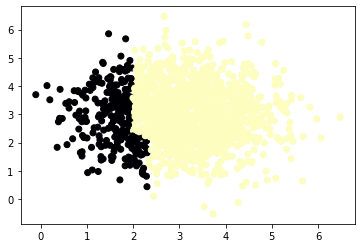

In [91]:
import matplotlib.pylab as plt
plt.scatter(x= sample_v[:, 0], y= sample_v[:, 1], c=class_v, cmap='magma')